In [2]:
# from pyspark import SparkContext 
# from pyspark.sql import SQLContext 
# import pandas as pd
# import numpy as np
# from pandas import DataFrame
# sc = SparkContext.getOrCreate()
# sqlc=SQLContext(sc)

import math
import matplotlib.pyplot as plt
from scipy.stats import norm, entropy 
from scipy.stats import probplot
import matplotlib.pyplot as plt
from scipy.stats import logistic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import resample
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from scipy.spatial.distance import cosine, correlation
import seaborn as sns
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
#reading csv file data in a dataframe
#[1]https://stackoverflow.com/questions/46311133/creating-dynamic-data-frames-in-python?rq=1
df_names=['df07','df08','df09','df10','df11','df12','df13','df14','df15','df16','df17','df18']
years=['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
d = {}
for name,i in zip(df_names,years):
    d[name] = pd.DataFrame()
    d[name]=pd.read_csv('data-csv/chs'+str(i)+'_public.csv')    


In [4]:
# df=df18.copy()
df=d['df17']
df.head()

,qxvers,mood63,mood64,mood54,mood55,mood56,mood57,mood58,mood59,mood61,...,condomusetrend,drinker,daysalc30,averagedrink17,heavydrink17,bingenew,reasontravel3_q1,bthcntrltype17,hhsize,child
0,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,2.0,0.0,0.000000,2.0,2.0,NaN,1.0,7,1.0
1,1,NaN,3.0,1.0,2.0,1.0,3.0,NaN,1.0,NaN,...,2.0,1.0,1.0,0.033333,2.0,2.0,NaN,NaN,4,1.0
2,1,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,NaN,...,NaN,2.0,0.0,0.000000,2.0,2.0,NaN,NaN,2,2.0
3,1,1.0,1.0,4.0,4.0,1.0,1.0,2.0,1.0,NaN,...,NaN,1.0,1.0,0.033333,2.0,2.0,NaN,NaN,2,NaN
4,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,2.0,0.0,0.000000,2.0,2.0,NaN,NaN,1,2.0


In [5]:
#number of features
len(df.columns)

133

In [6]:
df.columns

Index(['qxvers', 'mood63', 'mood64', 'mood54', 'mood55', 'mood56', 'mood57',
       'mood58', 'mood59', 'mood61',
       ...
       'condomusetrend', 'drinker', 'daysalc30', 'averagedrink17',
       'heavydrink17', 'bingenew', 'reasontravel3_q1', 'bthcntrltype17',
       'hhsize', 'child'],
      dtype='object', length=133)

In [7]:
#number of rows
len(df["qxvers"])

10005

In [8]:
df.isnull().sum()

qxvers                 0
mood63               182
mood64               105
mood54               121
mood55               145
                    ... 
bingenew             132
reasontravel3_q1    9246
bthcntrltype17      6056
hhsize                 0
child                 45
Length: 133, dtype: int64

qxvers-Questionnaire version
nutrition46-cupsof fruit
nutrition47-cups of vegetable

# Steps followed for analysis
#process NA values
#find correlation between target and source variables and perform dimensionality reduction
#divide data into training and test sets
#apply regression
#reduce parameters depending upon correlartion
#apply regression again and compare models

In [9]:
#correlation function
#[1]https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
#[2]https://seaborn.pydata.org/examples/many_pairwise_correlations.html
def draw_corr(corr_var):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_var, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(
        corr_var, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        mask=mask,
#         annot=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

# Checking correlation between physical activity data

In [10]:
df_train_physical=df[["cid","exercise17","cyclingfreq","cycling17","generalhealth"]]

In [11]:
df_train_physical.isnull().sum()

cid               0
exercise17        5
cyclingfreq      21
cycling17        21
generalhealth    34
dtype: int64

In [12]:
#since imputed_PA08_3R_q1 has 5000+ values as N/A we will drop this column
df_train_physical=df_train_physical[["cid","exercise17","cyclingfreq","cycling17","generalhealth"]]
df_train_physical.head()

,cid,exercise17,cyclingfreq,cycling17,generalhealth
0,1800001,1.0,3.0,2.0,3.0
1,1800002,2.0,5.0,5.0,4.0
2,1800003,2.0,5.0,5.0,4.0
3,1800004,1.0,5.0,5.0,3.0
4,1800005,2.0,5.0,5.0,3.0


In [13]:
#dropping NaN values
df_train_physical=df_train_physical.dropna()
df_train_physical.head()

,cid,exercise17,cyclingfreq,cycling17,generalhealth
0,1800001,1.0,3.0,2.0,3.0
1,1800002,2.0,5.0,5.0,4.0
2,1800003,2.0,5.0,5.0,4.0
3,1800004,1.0,5.0,5.0,3.0
4,1800005,2.0,5.0,5.0,3.0


In [14]:
#correlation
#[1]https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
corr_1 = df_train_physical.corr()
corr_1

,cid,exercise17,cyclingfreq,cycling17,generalhealth
cid,1.000000,-0.046785,-0.145870,-0.147426,-0.125651
exercise17,-0.046785,1.000000,0.151944,0.148449,0.208027
cyclingfreq,-0.145870,0.151944,1.000000,0.952796,0.192472
cycling17,-0.147426,0.148449,0.952796,1.000000,0.185225
generalhealth,-0.125651,0.208027,0.192472,0.185225,1.000000


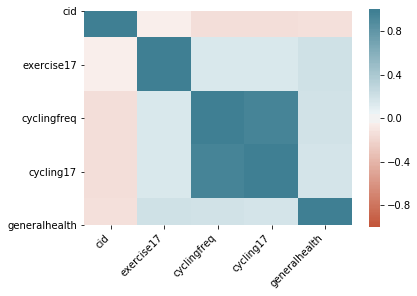

In [15]:
ax = sns.heatmap(
    corr_1, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#we see that cyclingfreq and cycling17 are highly correlated, so we can remove one of them. We remove cycling18 as it is less relevent out of the two for our analysis

In [16]:
df_train_physical=df_train_physical[["cid","exercise17","cyclingfreq","generalhealth"]]
df_train_physical.head()

,cid,exercise17,cyclingfreq,generalhealth
0,1800001,1.0,3.0,3.0
1,1800002,2.0,5.0,4.0
2,1800003,2.0,5.0,4.0
3,1800004,1.0,5.0,3.0
4,1800005,2.0,5.0,3.0


               exercise17  cyclingfreq  generalhealth
exercise17       1.000000     0.151944       0.208027
cyclingfreq      0.151944     1.000000       0.192472
generalhealth    0.208027     0.192472       1.000000


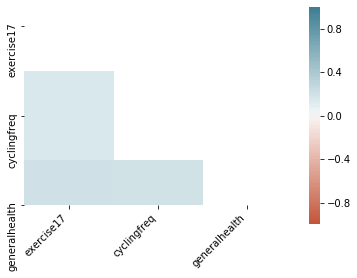

In [17]:
corr_2 = df_train_physical[["exercise17","cyclingfreq","generalhealth"]].corr()
draw_corr(corr_2)
print(corr_2)
#All have positive correlation. exercise18 is most correlated to general health

# Checking correlation between Nutrition data

In [18]:
df_train_nutrition = df[["nutrition46","nutrition47","fruitveg17",
                         "nsodaperday17","avgsodaperday17","twoplussoda",
                         "nsugardrinkperday17","avgsugarperday17","nsodasugarperday17",
                         "avgsodasugarperday17","ssb",
                         "generalhealth"]]
print(df_train_nutrition.head())
df_train_nutrition.isnull().sum()


   nutrition46  nutrition47  fruitveg17  nsodaperday17  avgsodaperday17  \
0          1.0          1.0         2.0       0.142857              2.0   
1          1.0          1.0         2.0       0.033058              2.0   
2          1.0          1.0         2.0       0.000000              1.0   
3          0.0          0.0         1.0       0.066116              2.0   
4          0.0          1.0         2.0       0.033058              2.0   

   twoplussoda  nsugardrinkperday17  avgsugarperday17  nsodasugarperday17  \
0          2.0             0.000000               1.0            0.142857   
1          2.0             0.000000               1.0            0.033058   
2          2.0             1.000000               3.0            1.000000   
3          2.0             0.033058               2.0            0.099174   
4          2.0             1.000000               3.0            1.033058   

   avgsodasugarperday17  ssb  generalhealth  
0                   2.0  2.0            

nutrition46             134
nutrition47             171
fruitveg17              254
nsodaperday17            65
avgsodaperday17          65
twoplussoda              65
nsugardrinkperday17     101
avgsugarperday17        101
nsodasugarperday17       83
avgsodasugarperday17     83
ssb                      83
generalhealth            34
dtype: int64

avgsugarperday17      generalhealth       0.002275
generalhealth         avgsugarperday17    0.002275
                      avgsodaperday17     0.003586
avgsodaperday17       generalhealth       0.003586
avgsodasugarperday17  generalhealth       0.008651
                                            ...   
nsodaperday17         nsodaperday17       1.000000
fruitveg17            fruitveg17          1.000000
nutrition47           nutrition47         1.000000
ssb                   ssb                 1.000000
generalhealth         generalhealth       1.000000
Length: 144, dtype: float64

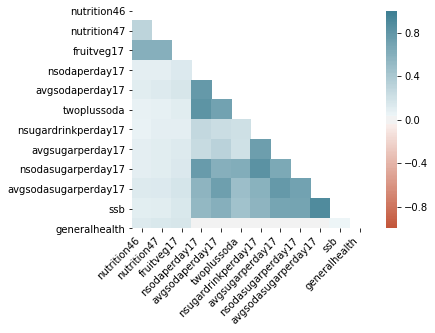

In [19]:
#[1]https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

df_train_nutrition=df_train_nutrition.dropna()
corr_3 = df_train_nutrition.corr().abs()
draw_corr(corr_3)

corr_3.unstack().sort_values(kind="quicksort")


avgsugarperday17  generalhealth       0.002275
generalhealth     avgsugarperday17    0.002275
avgsodaperday17   generalhealth       0.003586
generalhealth     avgsodaperday17     0.003586
ssb               generalhealth       0.039407
generalhealth     ssb                 0.039407
avgsugarperday17  nutrition46         0.089620
nutrition46       avgsugarperday17    0.089620
ssb               nutrition46         0.106992
nutrition46       ssb                 0.106992
nutrition47       ssb                 0.110719
ssb               nutrition47         0.110719
nutrition47       avgsugarperday17    0.112929
avgsugarperday17  nutrition47         0.112929
nutrition46       avgsodaperday17     0.114011
avgsodaperday17   nutrition46         0.114011
nutrition47       avgsodaperday17     0.118229
avgsodaperday17   nutrition47         0.118229
generalhealth     nutrition46         0.120746
nutrition46       generalhealth       0.120746
generalhealth     nutrition47         0.150984
nutrition47  

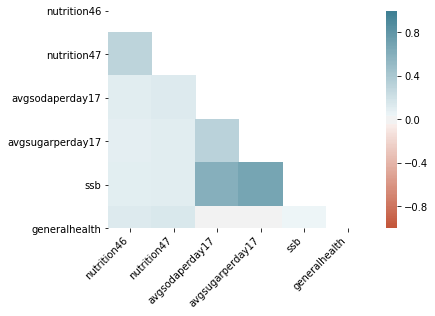

In [20]:
# features dropped pertaining to high correlation with other features :  
df_train_nutrition = df_train_nutrition[["nutrition46","nutrition47"
                        ,"avgsodaperday17"
                        ,"avgsugarperday17"
                         ,"ssb"
                         ,"generalhealth"]]

#finding correlation in remaining features
corr_nutrition = df_train_nutrition.corr().abs()
draw_corr(corr_nutrition)
corr_nutrition.unstack().sort_values(kind="quicksort")


#Next most correlated columns after deleting the previous coulmns:

nutrition47       fruitveg18          0.597664
fruitveg18        nutrition46         0.624137
avgsodaperday18   ssb                 0.626788

ssb               avgsugarperday18   -0.687271

ssb is correlated to both avgsodaperday18 and avgsugarperday18. We will keep ssb as it combines both soda and other drinks consumed by an individual. Also nutrition47 and fruitveg18 are correlated. Lets keep them for now as corelation is not very strong.

In [159]:
# features dropped pertaining to high correlation with other features :  
df_train_nutrition = df_train_nutrition[["nutrition46","nutrition47"
                         ,"ssb"
                         ,"generalhealth"]]

# Making prediction and checking rmse

In [21]:
#[1]https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
#[2]https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#[3]https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#[4]https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from math import sqrt

#function for rmse calculation of model
def model_apply(x,y,algo,n):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    scaler = StandardScaler()
    # Fit on training set only.
    scaler.fit(x_train)
    # Apply transform to both the training set and the test set.
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    pca = PCA(n_components=n,tol=.95)
    pca.fit(x_test)
    print(pca.explained_variance_ratio_) 
    
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)
    
#     principalDf = pd.DataFrame(data = x_train
#              , columns = ['pc1', 'pc2','pc3'])
#     print(principalDf)

    #model selection
    if algo==1:
        model=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=200)
    elif algo==2:
        model=GaussianNB()
    elif algo==3:
        model=DecisionTreeClassifier()
    elif algo==4:
        model=svm.SVC(gamma='scale')
    elif algo==5:
        model=Perceptron(tol=1e-3, random_state=0)
        
        # Train the model using the training sets
    model.fit(x_train,y_train.values.ravel())

    # Predict Output
    y_pred = model.predict(x_test)
    print ("Predicted Value:", y_pred)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    return(rmse)

# Physical Activity vs General Health

In [22]:
#preparing training and test data
x=df_train_physical[["exercise17","cyclingfreq"]] #source feature
y=df_train_physical[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1085
# model = GaussianNB() #rmse=1.28

In [31]:
model_apply(x,y,3,2)

[0.58630123 0.41369877]
Predicted Value: [2. 3. 4. ... 3. 3. 2.]
Accuracy: 0.32971451548049857
[[  0 105 254   5   0]
 [  0 155 516   9   0]
 [  0 124 648  14   0]
 [  0  47 447  17   0]
 [  0   7 126  13   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       364
         2.0       0.35      0.23      0.28       680
         3.0       0.33      0.82      0.47       786
         4.0       0.29      0.03      0.06       511
         5.0       0.00      0.00      0.00       146

    accuracy                           0.33      2487
   macro avg       0.19      0.22      0.16      2487
weighted avg       0.26      0.33      0.24      2487



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1112250310183447

# Nutrition vs General Health

In [47]:
#preparing training and test data
x=df_train_nutrition[["nutrition46","nutrition47","ssb"]] #source feature
y=df_train_nutrition[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1.1635
# model = GaussianNB() #rmse=1.28
model_apply(x,y,3,3)

[0.44593437 0.32665567 0.22740996]
Predicted Value: [3. 2. 3. ... 3. 3. 2.]
Accuracy: 0.3087806908031627
[[  4 171 230   1   0]
 [  8 225 421   0   0]
 [  4 195 512   0   0]
 [  3  99 367   1   0]
 [  2  28 132   0   0]]
              precision    recall  f1-score   support

         1.0       0.19      0.01      0.02       406
         2.0       0.31      0.34      0.33       654
         3.0       0.31      0.72      0.43       711
         4.0       0.50      0.00      0.00       470
         5.0       0.00      0.00      0.00       162

    accuracy                           0.31      2403
   macro avg       0.26      0.22      0.16      2403
weighted avg       0.31      0.31      0.22      2403



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.179305536349643

# Checking correlation between CardioVascular Health data

In [48]:
df_train_cardio=df[["toldhighbp17","toldprescription17","takingmeds17","generalhealth"]]
print(df_train_cardio.head())
df_train_cardio.isnull().sum()

   toldhighbp17  toldprescription17  takingmeds17  generalhealth
0           2.0                 NaN           NaN            3.0
1           2.0                 NaN           NaN            4.0
2           1.0                 1.0           1.0            4.0
3           2.0                 NaN           NaN            3.0
4           1.0                 2.0           NaN            3.0


toldhighbp17            34
toldprescription17    6524
takingmeds17          6901
generalhealth           34
dtype: int64

toldprescription18 and takingmeds18 has high NA values so we have to drop them from dataset

In [49]:
df_train_cardio=df[["toldhighbp17","generalhealth"]]
print(df_train_cardio.head())
df_train_cardio.isnull().sum()

   toldhighbp17  generalhealth
0           2.0            3.0
1           2.0            4.0
2           1.0            4.0
3           2.0            3.0
4           1.0            3.0


toldhighbp17     34
generalhealth    34
dtype: int64

toldhighbp17   generalhealth    0.316189
generalhealth  toldhighbp17     0.316189
toldhighbp17   toldhighbp17     1.000000
generalhealth  generalhealth    1.000000
dtype: float64

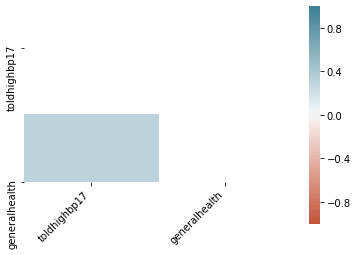

In [50]:
df_train_cardio=df_train_cardio.dropna()
corr_cardio = df_train_cardio.corr().abs()
draw_corr(corr_cardio)
corr_cardio.unstack().sort_values(kind="quicksort")

# Cardio vs General Health


In [54]:
df_train_cardio=df_train_cardio[["toldhighbp17","generalhealth"]]
df_train_cardio=df_train_cardio.dropna()
#preparing training and test data
x=df_train_cardio[["toldhighbp17"]] #source feature
y=df_train_cardio[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.15
# model = GaussianNB() #rmse=1.28
model_apply(x,y,3,1)

[1.]
Predicted Value: [3. 2. 2. ... 2. 2. 3.]
Accuracy: 0.30824949698189136
[[  0 355  73   0   0]
 [  0 490 148   0   0]
 [  0 504 276   0   0]
 [  0 224 259   0   0]
 [  0  47 109   0   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       428
         2.0       0.30      0.77      0.43       638
         3.0       0.32      0.35      0.34       780
         4.0       0.00      0.00      0.00       483
         5.0       0.00      0.00      0.00       156

    accuracy                           0.31      2485
   macro avg       0.12      0.22      0.15      2485
weighted avg       0.18      0.31      0.22      2485



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1546424533902373

# Checking correlation between Diabetes data

In [55]:
df_train_diabetes=df[["diabetes17","generalhealth"]]
print(df_train_diabetes.head())
df_train_diabetes.isnull().sum()

   diabetes17  generalhealth
0         2.0            3.0
1         2.0            4.0
2         2.0            4.0
3         2.0            3.0
4         2.0            3.0


diabetes17       19
generalhealth    34
dtype: int64

Since only one column is there is no need to check correlation here.

# Diabetes vs General Health 

In [58]:
df_train_diabetes=df_train_diabetes[["diabetes17","generalhealth"]]
df_train_diabetes=df_train_diabetes.dropna()
#preparing training and test data
x=df_train_diabetes[["diabetes17"]] #source feature
y=df_train_diabetes[["generalhealth"]] #target feature
# algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.1714
# algo=svm.SVC(gamma='scale') #emse=1.1714
# algo = GaussianNB() #rmse=1.2356
# algo=DecisionTreeClassifier() #rmse=1.1714
model_apply(x,y,3,1)

[1.]
Predicted Value: [3. 3. 3. ... 3. 3. 3.]
Accuracy: 0.33038585209003213
[[  0   0 399  19   0]
 [  0   0 610  42   0]
 [  0   0 684  90   0]
 [  0   0 351 138   0]
 [  0   0  91  64   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       418
         2.0       0.00      0.00      0.00       652
         3.0       0.32      0.88      0.47       774
         4.0       0.39      0.28      0.33       489
         5.0       0.00      0.00      0.00       155

    accuracy                           0.33      2488
   macro avg       0.14      0.23      0.16      2488
weighted avg       0.18      0.33      0.21      2488



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.1714036431464812

# Clubbing the different parameters

In [59]:
#df_train_physical[["exercise17","cyclingfreq","generalhealth"]]
#df_train_diabetes[["diabetes17","generalhealth"]]
#df_train_cardio[["toldhighbp17","generalhealth"]]
#df_train_nutrition[["nutrition46","nutrition47","ssb"]]
df_clubbed=df[["cid","exercise17","cyclingfreq","nutrition46","nutrition47","ssb",
              "diabetes17","toldhighbp17","generalhealth"]]
print(df_clubbed.head())
df_clubbed.isnull().sum()

       cid  exercise17  cyclingfreq  nutrition46  nutrition47  ssb  \
0  1800001         1.0          3.0          1.0          1.0  2.0   
1  1800002         2.0          5.0          1.0          1.0  2.0   
2  1800003         2.0          5.0          1.0          1.0  1.0   
3  1800004         1.0          5.0          0.0          0.0  2.0   
4  1800005         2.0          5.0          0.0          1.0  1.0   

   diabetes17  toldhighbp17  generalhealth  
0         2.0           2.0            3.0  
1         2.0           2.0            4.0  
2         2.0           1.0            4.0  
3         2.0           2.0            3.0  
4         2.0           1.0            3.0  


cid                0
exercise17         5
cyclingfreq       21
nutrition46      134
nutrition47      171
ssb               83
diabetes17        19
toldhighbp17      34
generalhealth     34
dtype: int64

In [145]:
df_clubbed=df_clubbed.dropna()
#preparing training and test data
x=df_clubbed.drop(columns=["cid","generalhealth"]) #source feature
y=df_clubbed[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=1.10462
# algo=svm.SVC(gamma='scale') #emse=1.1607
# algo = GaussianNB() #rmse=1.2136
# algo=DecisionTreeClassifier() #rmse=1.4525
model_apply(x,y,1,4)

[0.24669636 0.19843716 0.14674366 0.13256473]
Predicted Value: [3. 3. 3. ... 3. 2. 3.]
Accuracy: 0.3717735220649459
[[  6 224 140  14   0]
 [  7 331 316  32   0]
 [  1 219 442  78   1]
 [  0  82 254 112   2]
 [  0  15  50  74   2]]
              precision    recall  f1-score   support

         1.0       0.43      0.02      0.03       384
         2.0       0.38      0.48      0.43       686
         3.0       0.37      0.60      0.45       741
         4.0       0.36      0.25      0.29       450
         5.0       0.40      0.01      0.03       141

    accuracy                           0.37      2402
   macro avg       0.39      0.27      0.25      2402
weighted avg       0.38      0.37      0.32      2402



1.052137905183408

# Physical Activity vs Cardio Health

In [89]:
#preparing training and test data
x=df_clubbed[["exercise17","cyclingfreq"]] #source feature
y=df_clubbed[["toldhighbp17"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5800
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[0.58330164]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.6727726894254787
[[  33  775]
 [  11 1583]]
              precision    recall  f1-score   support

         1.0       0.75      0.04      0.08       808
         2.0       0.67      0.99      0.80      1594

    accuracy                           0.67      2402
   macro avg       0.71      0.52      0.44      2402
weighted avg       0.70      0.67      0.56      2402



0.5720378576410142

# Nutrition vs Cardio Health

In [97]:
#preparing training and test data
x=df_clubbed[["nutrition46","nutrition47","ssb"]] #source feature
y=df_clubbed[["toldhighbp17"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.5800
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,2)

[0.51975227 0.30847363]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.6598667776852623
[[   8  800]
 [  17 1577]]
              precision    recall  f1-score   support

         1.0       0.32      0.01      0.02       808
         2.0       0.66      0.99      0.79      1594

    accuracy                           0.66      2402
   macro avg       0.49      0.50      0.41      2402
weighted avg       0.55      0.66      0.53      2402



0.583209415488757

# Physical vs Diabetes

In [101]:
#preparing training and test data
x=df_clubbed[["exercise17","cyclingfreq"]] #source feature
y=df_clubbed[["diabetes17"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3723
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,2)

[0.58330164 0.41669836]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.8613655287260616
[[   0  333]
 [   0 2069]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       333
         2.0       0.86      1.00      0.93      2069

    accuracy                           0.86      2402
   macro avg       0.43      0.50      0.46      2402
weighted avg       0.74      0.86      0.80      2402



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.3723365027417247

# Nutrition vs Diabetes

In [105]:
#preparing training and test data
x=df_clubbed[["nutrition46","nutrition47","ssb"]] #source feature
y=df_clubbed[["diabetes17"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3723
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[0.51975227]
Predicted Value: [2. 2. 2. ... 2. 2. 2.]
Accuracy: 0.8592839300582847
[[   0  333]
 [   5 2064]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       333
         2.0       0.86      1.00      0.92      2069

    accuracy                           0.86      2402
   macro avg       0.43      0.50      0.46      2402
weighted avg       0.74      0.86      0.80      2402



0.3751214069360948

We observed that most of the Diabetes predictions are of class 2. Probably there is an imbalace of class in test data. Let us check.

# Resampling Diabetese Dataset

In [106]:
#[1]https://elitedatascience.com/imbalanced-classes
df_clubbed["diabetes17"].value_counts()

2.0    8212
1.0    1393
Name: diabetes17, dtype: int64

As we can see that class 2 has more samples than class 1 which shows that data is impbalanced and fovours class 2. Upsampling the class 1 data :

# Up Sampling

In [107]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df_clubbed[df_clubbed.diabetes17==2]
df_minority = df_clubbed[df_clubbed.diabetes17==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8212,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.diabetes17.value_counts()

1.0    8212
2.0    8212
Name: diabetes17, dtype: int64

# Nutrition vs Diabetes again after upsampling

In [113]:
#preparing training and test data
x=df_upsampled[["nutrition46","nutrition47","ssb"]] #source feature
y=df_upsampled[["diabetes17"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.6438
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[0.46540266]
Predicted Value: [1. 2. 1. ... 1. 2. 2.]
Accuracy: 0.5864588407208963
[[1275  820]
 [ 878 1133]]
              precision    recall  f1-score   support

         1.0       0.59      0.61      0.60      2095
         2.0       0.58      0.56      0.57      2011

    accuracy                           0.59      4106
   macro avg       0.59      0.59      0.59      4106
weighted avg       0.59      0.59      0.59      4106



0.6430716595210084

# Physical Activity vs Diabetes after upsampling

In [119]:
#preparing training and test data
x=df_upsampled[["exercise17","cyclingfreq"]] #source feature
y=df_upsampled[["diabetes17"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3937
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[0.56081638]
Predicted Value: [1. 2. 2. ... 1. 1. 1.]
Accuracy: 0.5686799805163176
[[1906  189]
 [1582  429]]
              precision    recall  f1-score   support

         1.0       0.55      0.91      0.68      2095
         2.0       0.69      0.21      0.33      2011

    accuracy                           0.57      4106
   macro avg       0.62      0.56      0.50      4106
weighted avg       0.62      0.57      0.51      4106



0.6567495865881321

# Down Sampling

In [120]:
#Down Sampling
df_majority = df_clubbed[df_clubbed.diabetes17==2]
df_minority = df_clubbed[df_clubbed.diabetes17==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1393,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.diabetes17.value_counts()

1.0    1393
2.0    1393
Name: diabetes17, dtype: int64

# Nutrition vs Diabetes again after down sampling

In [131]:
#preparing training and test data
x=df_downsampled[["nutrition46","nutrition47","ssb"]] #source feature
y=df_downsampled[["diabetes17"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3937
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,2)

[0.46545593 0.37306958]
Predicted Value: [1. 1. 2. 1. 1. 1. 2. 1. 2. 1. 1. 2. 2. 2. 2. 2. 1. 1. 2. 1. 1. 2. 2. 1.
 1. 2. 1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 2. 2. 2. 1. 2. 1. 1.
 2. 1. 2. 1. 1. 1. 2. 2. 2. 2. 1. 2. 2. 2. 1. 1. 1. 2. 2. 1. 1. 1. 2. 1.
 1. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2.
 2. 2. 1. 1. 2. 1. 1. 2. 1. 1. 2. 1. 2. 2. 1. 1. 2. 2. 1. 1. 1. 1. 1. 2.
 2. 2. 2. 1. 1. 1. 2. 2. 1. 2. 1. 1. 2. 2. 1. 2. 1. 2. 1. 2. 2. 2. 1. 1.
 1. 1. 1. 1. 1. 2. 1. 2. 1. 2. 2. 1. 2. 1. 2. 1. 1. 2. 2. 2. 1. 2. 2. 1.
 2. 1. 2. 2. 2. 2. 1. 1. 2. 1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2.
 2. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 2. 1. 1. 1. 2. 1. 1. 2.
 2. 2. 2. 1. 1. 1. 2. 1. 2. 2. 1. 1. 1. 1. 2. 2. 1. 1. 1. 2. 1. 2. 1. 2.
 2. 1. 2. 2. 1. 1. 2. 1. 2. 1. 1. 1. 1. 2. 1. 2. 1. 2. 1. 1. 1. 2. 1. 1.
 2. 1. 1. 1. 1. 1. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 2. 2. 1.
 2. 1. 2. 2. 1. 2. 2. 1. 1. 2. 2. 2. 1. 1. 1. 1. 2. 2. 2. 2. 2. 1. 1. 2.
 2. 1. 1. 

0.6549666775012418

# Physical Activity vs Diabetes after down sampling

In [133]:
#preparing training and test data
x=df_downsampled[["exercise17","cyclingfreq"]] #source feature
y=df_downsampled[["diabetes17"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3937
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,1,1)

[0.57960066]
Predicted Value: [1. 2. 2. 2. 2. 1. 1. 1. 1. 2. 1. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2.
 2. 1. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 1. 2. 2. 2. 1. 2. 1. 2.
 2. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 1. 2. 1. 1. 2. 2.
 1. 2. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 1. 2. 1. 1. 2. 2. 1. 2. 2.
 2. 2. 1. 2. 2. 1. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2.
 1. 1. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 1. 2. 1. 2. 1. 2. 2. 2. 1.
 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 1. 2. 2. 2. 1. 2.
 2. 2. 1. 2. 2. 2. 1. 1. 1. 2. 2. 2. 2. 2. 1. 2. 1. 1. 2. 2. 1. 2. 2. 2.
 2. 1. 1. 1. 2. 2. 1. 2. 2. 2. 1. 2. 1. 1. 2. 2. 2. 1. 2. 2. 1. 2. 2. 1.
 1. 2. 1. 2. 2. 1. 1. 1. 2. 1. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2. 2.
 2. 1. 1. 2. 2. 1. 2. 1. 2. 2. 2. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2.
 1. 1. 1. 1. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 1. 2.
 2. 2. 2. 2. 2. 2. 1.

0.6701249374935909

After both Up and Down sampling the rmse is near about remains 0.66

# Marital Status vs Cardio Vascular Health

In [134]:
df_martial=df[["maritalstatus17","toldhighbp17","generalhealth"]]
df_martial=df_martial.dropna()

In [136]:
#preparing training and test data
x=df_martial[["maritalstatus17"]] #source feature
y=df_martial[["toldhighbp17"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') #rmse=0.3937
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [2. 1. 2. ... 2. 2. 2.]
Accuracy: 0.6753141467369275
[[ 148  738]
 [  63 1518]]
              precision    recall  f1-score   support

         1.0       0.70      0.17      0.27       886
         2.0       0.67      0.96      0.79      1581

    accuracy                           0.68      2467
   macro avg       0.69      0.56      0.53      2467
weighted avg       0.68      0.68      0.60      2467



0.5698121210215455

# Marital Status vs General Health Status

In [138]:
#preparing training and test data
x=df_martial[["maritalstatus17"]] #source feature
y=df_martial[["generalhealth"]] #target feature
algo=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') 
# algo=svm.SVC(gamma='scale') #emse=1.1806
# algo = GaussianNB() #rmse=1.2156
# algo=DecisionTreeClassifier() #rmse=1.4330
model_apply(x,y,3,1)

[1.]
Predicted Value: [2. 4. 3. ... 3. 3. 3.]
Accuracy: 0.3003648155654641
[[  0 128 255  13   0]
 [  0 235 387  40   0]
 [  0 251 443  64   0]
 [  0 102 322  63   0]
 [  0  32 101  31   0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       396
         2.0       0.31      0.35      0.33       662
         3.0       0.29      0.58      0.39       758
         4.0       0.30      0.13      0.18       487
         5.0       0.00      0.00      0.00       164

    accuracy                           0.30      2467
   macro avg       0.18      0.21      0.18      2467
weighted avg       0.23      0.30      0.25      2467



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.2046390535304077